<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/XAI/custom_one_with_LIME_Explainer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Constants
IMG_SIZE = 224
CATEGORIES = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
BATCH_SIZE = 32
EPOCHS = 25
DATA_DIR = '/content/drive/MyDrive/DSGP/dataset'

# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split for training and validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Calculate class weights to address imbalance
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_tensor = tf.constant([class_weights[i] for i in range(len(CATEGORIES))])

# Define a wrapper for the dual input generator
def dual_input_generator(generator):
    for x, y in generator:
        yield ((x, x), y)  # Return a tuple of inputs and labels

# Create datasets from the generators with output_signature
train_dual_dataset = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(train_generator),
    output_signature=(
        (tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(CATEGORIES)), dtype=tf.float32)
    )
)

val_dual_dataset = tf.data.Dataset.from_generator(
    lambda: dual_input_generator(val_generator),
    output_signature=(
        (tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(CATEGORIES)), dtype=tf.float32)
    )
)

# Model: Combine VGG16 and ResNet50 with custom layers
# Load pre-trained VGG16 and ResNet50
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the pre-trained layers
for layer in vgg_base.layers:
    layer.trainable = False

for layer in resnet_base.layers:
    layer.trainable = False

# Combine features from both models
vgg_features = vgg_base.output
resnet_features = resnet_base.output

# Apply Global Average Pooling to each
vgg_gap = GlobalAveragePooling2D()(vgg_features)
resnet_gap = GlobalAveragePooling2D()(resnet_features)

# Concatenate the outputs
merged_features = tf.keras.layers.concatenate([vgg_gap, resnet_gap])

# Add custom layers on top
x = Dense(256, activation='relu')(merged_features)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(len(CATEGORIES), activation='softmax')(x)

# Build the model
model = Model(inputs=[vgg_base.input, resnet_base.input], outputs=output)

# Define custom loss function with class weights
from tensorflow.keras.losses import CategoricalCrossentropy

def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.cast(class_weight_tensor, dtype=tf.float32)
    weighted = tf.reduce_sum(weights * y_true, axis=-1)
    unweighted_loss = CategoricalCrossentropy()(y_true, y_pred)
    return unweighted_loss * weighted

# Compile the model with the custom loss
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=weighted_categorical_crossentropy,
    metrics=['accuracy']
)

# Model summary
model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=7, restore_best_weights=True, verbose=1
    )
]

# Train the model
history = model.fit(
    train_dual_dataset,
    epochs=EPOCHS,
    validation_data=val_dual_dataset,
    callbacks=callbacks,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Evaluate the model
val_loss, val_acc = model.evaluate(val_dual_dataset, steps=len(val_generator))
print(f"Validation Accuracy: {val_acc:.4f}")

# Get predictions on the validation set
y_pred_probs = model.predict(val_dual_dataset, steps=len(val_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels for the validation set
y_true = val_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on Validation Set: {accuracy:.4f}")

# Save the model
model.save('/content/custom_eye_disease_model.h5')
print("Model saved successfully.")


Mounted at /content/drive
Found 3377 images belonging to 4 classes.
Found 842 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 38,960,068 (148.62 MB)

 Trainable params: 657,156 (2.51 MB)

 Non-trainable params: 38,302,912 (146.11 MB)

Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1703s 16s/step - accuracy: 0.4985 - loss: 1.3534 - val_accuracy: 0.7316 - val_loss: 0.6737 - learning_rate: 1.0000e-04
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7614 - loss: 0.6510 - val_accuracy: 0.7090 - val_loss: 0.7736 - learning_rate: 1.0000e-04
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 94s 891ms/step - accuracy: 0.8096 - loss: 0.5381 - val_accuracy: 0.7019 - val_loss: 0.8194 - learning_rate: 1.0000e-04
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 95s 905ms/step - accuracy: 0.8239 - loss: 0.4972 - val_accuracy: 0.7553 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8420 - loss: 0.4198 - val_accuracy: 0.7672 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 89s 847ms/step - accuracy: 0.8347 - loss: 0.4284 - val_accuracy: 0.7601 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 752ms/

Accuracy on Validation Set: 0.2601
Model saved successfully.


Selected validation data index: 252


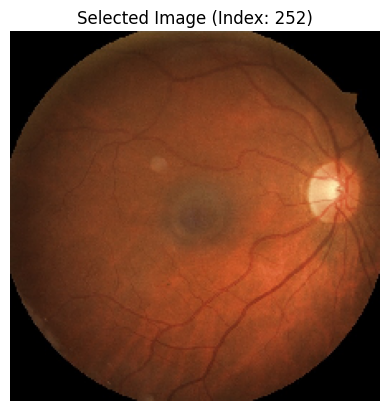

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

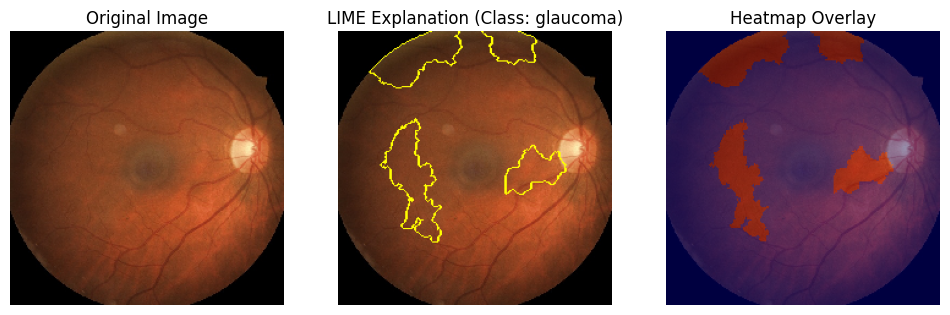

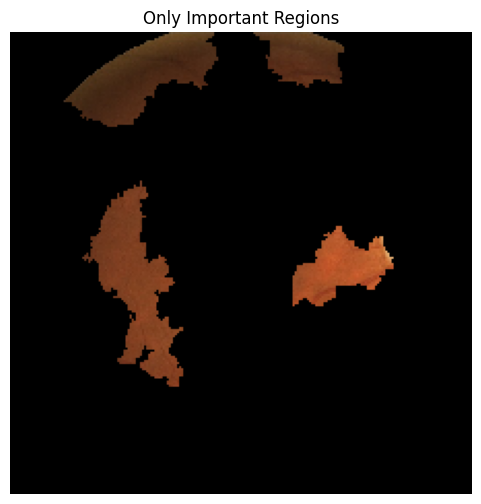

In [ ]:
!pip install lime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load the trained model
model = tf.keras.models.load_model('/content/custom_eye_disease_model.h5', compile=False)

# Select a random index from the validation dataset
random_index = random.randint(0, len(val_generator.filepaths) - 1)
sample_image_path = val_generator.filepaths[random_index]

# Load and preprocess the image
img = load_img(sample_image_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# Print the selected index
print(f"Selected validation data index: {random_index}")

# Display the image
plt.imshow(img)
plt.title(f"Selected Image (Index: {random_index})")
plt.axis('off')
plt.show()

# Define LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict probabilities for LIME
def predict_fn(images):
    images = np.array(images)
    return model.predict([images, images])  # Since the model has dual inputs

# Generate explanation for the selected image
explanation = explainer.explain_instance(
    img_array[0],  # LIME requires a single image (not batch)
    predict_fn,
    top_labels=4,  # Explain the 4 predicted classes
    hide_color=0,
    num_samples=1000  # Number of perturbed samples to generate
)

# Get the explanation for the predicted class
top_predicted_class = explanation.top_labels[0]

# Get the highlighted regions for positive influence
temp, mask = explanation.get_image_and_mask(
    top_predicted_class,
    positive_only=True,
    num_features=5,  # Number of superpixels to highlight
    hide_rest=False
)

# Convert mask to 8-bit format (0-255) for OpenCV
heatmap = np.uint8(255 * mask)

# Apply color mapping to create a heatmap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Convert both images to float32 for blending
temp_float = temp.astype(np.float32)  # Convert image to float
heatmap_float = heatmap.astype(np.float32) / 255.0  # Normalize heatmap

# Blend the heatmap with the original image
alpha = 0.5  # Transparency level
heatmap_overlay = cv2.addWeighted(temp_float, 0.6, heatmap_float, alpha, 0)

# Extract only important regions
important_regions = temp * mask[:, :, np.newaxis]  # Keep only highlighted parts

# Plot all results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# LIME with Mark Boundaries
plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation (Class: {CATEGORIES[top_predicted_class]})")
plt.axis('off')

# Heatmap Overlay
plt.subplot(1, 3, 3)
plt.imshow(heatmap_overlay)
plt.title("Heatmap Overlay")
plt.axis('off')

plt.show()

# Plot important regions separately
plt.figure(figsize=(6, 6))
plt.imshow(important_regions)
plt.title("Only Important Regions")
plt.axis('off')
plt.show()


Selected validation data index: 694


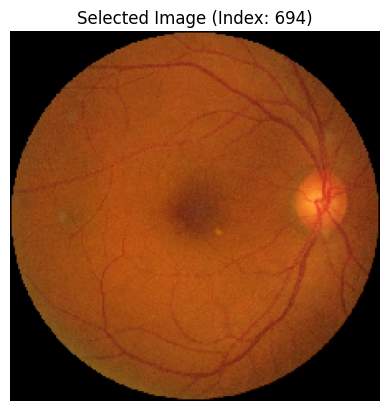

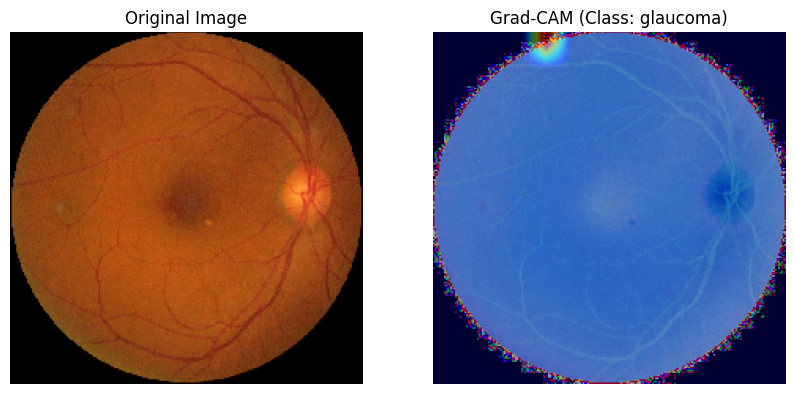

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model('/content/custom_eye_disease_model.h5', compile=False)

# Select a random index from the validation dataset
random_index = random.randint(0, len(val_generator.filepaths) - 1)
sample_image_path = val_generator.filepaths[random_index]

# Load and preprocess the image
img = load_img(sample_image_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# Print the selected index
print(f"Selected validation data index: {random_index}")

# Display the image
plt.imshow(img)
plt.title(f"Selected Image (Index: {random_index})")
plt.axis('off')
plt.show()

# Get the last convolutional layer from one of the base models
# Use the last convolutional layer of the VGG16 model
last_conv_layer_name = "block5_conv3"  # Last convolutional layer in VGG16

# Create a Grad-CAM model
grad_model = tf.keras.models.Model(
    inputs=[model.inputs],  # Dual inputs
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)

# Compute gradients for the last convolutional layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model([img_array, img_array])  # Dual inputs
    predicted_class = tf.argmax(predictions[0])  # Get the predicted class
    loss = predictions[:, predicted_class]  # Loss for the predicted class

# Gradients of the predicted class with respect to the output of the last convolutional layer
grads = tape.gradient(loss, conv_outputs)[0]

# Pool the gradients over all the axes leaving out the channel dimension
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Multiply each channel in the feature map array by the gradient importance
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normalize the heatmap
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

# Resize the heatmap to the original image size
heatmap = cv2.resize(heatmap.numpy(), (IMG_SIZE, IMG_SIZE))

# Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(
    cv2.cvtColor(np.uint8(np.array(img) * 255), cv2.COLOR_RGB2BGR), 0.6,  # Convert to BGR
    heatmap, 0.4, 0
)

# Convert back to RGB for display
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# Plot the results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM Heatmap
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM (Class: {CATEGORIES[predicted_class]})")
plt.axis('off')

plt.show()